In [15]:
from mylib.statistic_test import *

code_id = "0847 - Starting Point Field Cluster"
loc = join(figpath, "Dsp", code_id)
mkdir(loc)

def identify_unique_fields(trace):
    uniq_fields = []
    for i in tqdm(range(trace['n_neuron'])):
        uniq_field = {}
        for k in trace['place_field_all_new'][i].keys():
            field_area = trace['place_field_all_new'][i][k]
            
            n_encoded = 0
            route = -1
            for r in range(10):
                # 10 routes. If this field only encodes 1 route, it is unique
                
                # So-called encoding requires several criteria:
                # 1. It should has over 3 spikes
                # 2. Spikes should be distributed in over 3 laps.
                
                spike_idx = np.where(
                    (trace[f'node {r}']['Spikes'][i, :] == 1) &
                    (np.isin(trace[f'node {r}']['spike_nodes'], field_area))
                )[0]
                
                if spike_idx.shape[0] < 3:
                    continue
                
                dt = np.ediff1d(trace[f'node {r}']['ms_time_behav'][spike_idx])
                if np.where(dt >= 15000)[0].shape[0] < 3:
                    continue
                
                if route == trace[f'node {r}']['Route'] and route == 0:
                    continue
                
                n_encoded += 1
                route = trace[f'node {r}']['Route']
                
            if n_encoded == 1:
                uniq_field[k] = field_area, route
            
        uniq_fields.append(uniq_field)
                
    trace['uniq_field_all'] = uniq_fields
    return trace


        E:\Data\FinalResults\Dsp\0847 - Starting Point Field Cluster is already existed!


In [20]:
with open(f2['Trace File'][34], 'rb') as handle:
    trace = pickle.load(handle)
    
D = GetDMatrices(1, 48)
n = np.zeros(trace['n_neuron'], dtype=np.int64)
for i in range(trace['n_neuron']):
    for k in trace['uniq_field_all'][i].keys():
        if D[k-1, SP_DSP[trace['uniq_field_all'][i][k][1]]-1] / (np.max(D)+1e-8) * 888 < 100 and trace['uniq_field_all'][i][k][1] != 0:
            n[i] += 1

[0.53763441 0.29677419 0.10967742 0.02365591 0.02150538 0.00645161
 0.00430108 0.         0.         0.         0.         0.
 0.        ]
0.6055720159594816 0.00013100597615370624
2.798548556006924 0.8025708410169903 2.379591832613068e-05


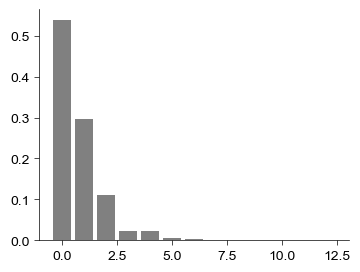

In [19]:
fig = plt.figure(figsize=(4, 3))
ax: Axes = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
a = ax.hist(n, range=(-0.5, 12.5), bins=13, density=True, rwidth=0.8, color='gray')[0]
print(a)

lam = EqualPoissonFit(np.arange(13), a, l0=1)
print(lam, np.mean((EqualPoissonResiduals(lam, np.arange(13), a))**2))

r, p = NegativeBinomialFit(np.arange(13), a)
print(r, p, np.mean((NegativeBinomialResiduals((r, p), np.arange(13), a))**2))

0it [00:00, ?it/s]C:\Users\12454\AppData\Local\Temp\ipykernel_38324\1633285581.py:186: RuntimeWarning: invalid value encountered in divide
  Hist['Density'].append(x0/x1)
4it [00:01,  2.86it/s]


<Axes: xlabel='Distances', ylabel='Density'>

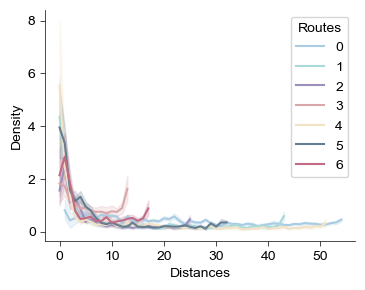

In [13]:
import scipy.stats


def get_data(trace):
    bins = []
    routes = []
    for i in range(len(trace['uniq_field_all'])):
        for k in trace['uniq_field_all'][i].keys():
            bins.append(k)
            routes.append(trace['uniq_field_all'][i][k][1])

    bins = np.array(bins, np.int64)
    routes = np.array(routes, np.int64)
    distances = np.zeros_like(bins, dtype=np.float64)
    D = GetDMatrices(1, 48)

    control_dist = []
    control_routes = []
    for i in range(7):
        idx = np.where(routes == i)[0]
    
        if idx.shape[0] == 0:
            continue
    
        distances[idx] = D[bins[idx]-1, SP_DSP[i]-1]

    for i in range(10):
        a_bins = trace[f'node {i}']['spike_nodes'].astype(np.int64)[idx]
        rt = trace[f'node {i}']['Route']
        control_dist.append(D[np.unique(a_bins-1), SP_DSP[rt]-1])
        control_routes.append(np.repeat(rt, np.unique(a_bins-1).shape[0]))

    control_dist = np.concatenate(control_dist)
    control_routes = np.concatenate(control_routes)
    x1 = distances/(np.max(D)+1e-8) * 111
    x2 = control_dist/(np.max(D)+1e-8) * 111
    
    res = {
        "MiceID": np.repeat(int(trace['MiceID']), x1.shape[0]+x2.shape[0]),
        "Distances": np.concatenate([x1, x2]),
        "Routes": np.concatenate([routes, control_routes]),
        "Type": np.concatenate([np.repeat('Unique', x1.shape[0]), np.repeat('Control', x2.shape[0])])
    }
    
    return res

if exists(join(figdata, code_id+'.pkl')) == False:
    Data = {
        "MiceID": [],
        "Distances": [],
        "Routes": [],
        "Type": [],
        "Training Day": []
    }
    
    for i in tqdm(range(len(f2))):
        with open(f2['Trace File'][i], 'rb') as handle:
            trace = pickle.load(handle)
        
        res = get_data(trace)
        res['Training Day'] = np.repeat(f2['training_day'][i], res['MiceID'].shape[0])
        
        for k in res.keys():
            Data[k].append(res[k])
            
    for k in Data.keys():
        Data[k] = np.concatenate(Data[k])
        
    with open(join(figdata, code_id+'.pkl'), 'wb') as handle:
        pickle.dump(Data, handle)
    
    print(Data['Distances'].shape)
    Hist = {
        "Distances": [],
        "Density": [],
        "MiceID": [],
        "Training Day": [],
        "Routes": []
    }
    
    dist = (Data['Distances'] // 2).astype(np.int64)
    
    for m, mouse in tqdm(enumerate([10212, 10224, 10227, 10232])):
        for r in range(7):
            for d in np.unique(Data['Training Day']):
                idx0 = np.where(
                    (Data['MiceID'] == mouse) &
                    (Data['Routes'] == r) &
                    (Data['Training Day'] == d) &
                    (Data['Type'] == 'Unique')
                )[0]
                
                idx1 = np.where(
                    (Data['MiceID'] == mouse) &
                    (Data['Routes'] == r) &
                    (Data['Training Day'] == d) &
                    (Data['Type'] == 'Control')
                )[0]
                
                _xmax = np.max(dist[idx0])
                
                x0 = scipy.stats.binned_statistic(
                    dist[idx0],
                    np.ones_like(dist[idx0], np.int64),
                    'sum',
                    bins=_xmax+1,
                    range=(0, _xmax+1e-8)
                )[0]
                
                x1 = scipy.stats.binned_statistic(
                    dist[idx1],
                    np.ones_like(dist[idx1], np.int64),
                    'sum',
                    bins=_xmax+1,
                    range=(0, _xmax+1e-8)
                )[0]
                
                Hist['Distances'].append(np.arange(_xmax+1))
                Hist['Density'].append(x0/x1)
                Hist['MiceID'].append(np.repeat(mouse, _xmax+1))
                Hist['Training Day'].append(np.repeat(d, _xmax+1))
                Hist['Routes'].append(np.repeat(r, _xmax+1))
    
    for k in Hist.keys():
        Hist[k] = np.concatenate(Hist[k])
        
    with open(join(figdata, code_id+' [Histogram].pkl'), 'wb') as handle:
        pickle.dump(Hist, handle)
        
    D = pd.DataFrame(Hist)
    D.to_excel(join(figdata, code_id+' [Histogram].xlsx'), index=False)    

else:
    with open(join(figdata, code_id+'.pkl'), 'rb') as handle:
        Data = pickle.load(handle)
    
    Hist = {
        "Distances": [],
        "Density": [],
        "MiceID": [],
        "Training Day": [],
        "Routes": []
    }
    
    dist = (Data['Distances'] // 2).astype(np.int64)
    
    for m, mouse in tqdm(enumerate([10212, 10224, 10227, 10232])):
        for r in range(7):
            for d in np.unique(Data['Training Day']):
                idx0 = np.where(
                    (Data['MiceID'] == mouse) &
                    (Data['Routes'] == r) &
                    (Data['Training Day'] == d) &
                    (Data['Type'] == 'Unique')
                )[0]
                
                idx1 = np.where(
                    (Data['MiceID'] == mouse) &
                    (Data['Routes'] == r) &
                    (Data['Training Day'] == d) &
                    (Data['Type'] == 'Control')
                )[0]
                
                _xmax = np.max(dist[idx0])
                
                x0 = scipy.stats.binned_statistic(
                    dist[idx0],
                    np.ones_like(dist[idx0], np.int64),
                    'sum',
                    bins=_xmax+1,
                    range=(0, _xmax+1e-8)
                )[0]
                
                x1 = scipy.stats.binned_statistic(
                    dist[idx1],
                    np.ones_like(dist[idx1], np.int64),
                    'sum',
                    bins=_xmax+1,
                    range=(0, _xmax+1e-8)
                )[0]
                
                Hist['Distances'].append(np.arange(_xmax+1))
                Hist['Density'].append(x0/x1)
                Hist['MiceID'].append(np.repeat(mouse, _xmax+1))
                Hist['Training Day'].append(np.repeat(d, _xmax+1))
                Hist['Routes'].append(np.repeat(r, _xmax+1))
    
    for k in Hist.keys():
        Hist[k] = np.concatenate(Hist[k])
        
    with open(join(figdata, code_id+' [Histogram].pkl'), 'wb') as handle:
        pickle.dump(Hist, handle)
        
    D = pd.DataFrame(Hist)
    D.to_excel(join(figdata, code_id+' [Histogram].xlsx'), index=False)  
    
    with open(join(figdata, code_id+' [Histogram].pkl'), 'rb') as handle:
        Hist = pickle.load(handle)

                
fig = plt.figure(figsize=(4, 3))
ax: Axes = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
sns.lineplot(
    x='Distances', 
    y='Density',  
    data=Hist,
    hue='Routes',
    palette=DSPPalette
)

In [ ]:
from mylib.statistic_test import *

for i in range(546, len(f1)):
    if f1['include'][i] == 0:
        continue
    
    if f1['MiceID'][i] not in [10209, 10212, 10224, 10227, 10232, 10234]:
        continue
    
    print(i, f1['Trace File'][i])
    
    targ_dir = join(r"F:\Data\Cross_maze", str(f1['MiceID'][i]), str(f1['date'][i]), 'session '+str(f1['session'][i]))
    if os.path.exists(targ_dir) == False:
        os.makedirs(targ_dir)
    
    try:
        shutil.copy(f1['Trace File'][i], join(targ_dir, "trace.pkl"))
        shutil.copy(f1['Trace Behav File'][i], join(targ_dir, "trace_behav.pkl"))
    except:
        pass

546 G:\Data\Cross_maze\10232\20240829\session 1\trace.pkl
